## 1. Import Libraries

In [1]:
# Standard libraries
import os
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Image processing
import cv2
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 2. Dataset Configuration

In [2]:
# Define dataset paths and class labels
DATASET_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\dataset')
BLOOD_GROUPS = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

# Verify dataset exists
assert DATASET_PATH.exists(), f"Dataset path not found: {DATASET_PATH}"
print(f"Dataset path: {DATASET_PATH}")
print(f"Blood groups: {BLOOD_GROUPS}")

Dataset path: C:\Users\phoga\Desktop\HemoPrint\dataset
Blood groups: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


## 3. Dataset Statistics Collection

In [3]:
# Collect dataset statistics
def collect_dataset_statistics(dataset_path, blood_groups):
    """
    Collect comprehensive statistics about the dataset including:
    - Number of images per class
    - Image dimensions
    - File sizes
    - Color channels
    """
    stats = {
        'blood_group': [],
        'num_images': [],
        'avg_height': [],
        'avg_width': [],
        'avg_file_size_kb': [],
        'image_paths': []
    }
    
    for group in blood_groups:
        group_path = dataset_path / group
        
        if not group_path.exists():
            print(f"Warning: {group} folder not found")
            continue
            
        # Get all BMP images
        image_files = list(group_path.glob('*.BMP'))
        num_images = len(image_files)
        
        if num_images == 0:
            print(f"Warning: No images found in {group}")
            continue
        
        # Sample images for dimension analysis (first 50 for speed)
        sample_images = image_files[:min(50, num_images)]
        heights, widths, file_sizes = [], [], []
        
        for img_path in sample_images:
            try:
                # Get image dimensions
                img = Image.open(img_path)
                w, h = img.size
                widths.append(w)
                heights.append(h)
                
                # Get file size
                file_sizes.append(img_path.stat().st_size / 1024)  # KB
            except Exception as e:
                print(f"Error reading {img_path}: {e}")
        
        # Store statistics
        stats['blood_group'].append(group)
        stats['num_images'].append(num_images)
        stats['avg_height'].append(np.mean(heights) if heights else 0)
        stats['avg_width'].append(np.mean(widths) if widths else 0)
        stats['avg_file_size_kb'].append(np.mean(file_sizes) if file_sizes else 0)
        stats['image_paths'].append(image_files)
    
    return pd.DataFrame(stats)

# Collect statistics
print("Collecting dataset statistics...")
df_stats = collect_dataset_statistics(DATASET_PATH, BLOOD_GROUPS)
print("\nDataset Statistics:")
print(df_stats[['blood_group', 'num_images', 'avg_height', 'avg_width', 'avg_file_size_kb']])


Dataset Statistics:
  blood_group  num_images  avg_height  avg_width  avg_file_size_kb
0          A+         565       103.0       96.0         38.759766
1          A-        1009       103.0       96.0         38.759766
2         AB+         708       103.0       96.0         38.759766
3         AB-         761       103.0       96.0         38.759766
4          B+         652       103.0       96.0         38.759766
5          B-         741       103.0       96.0         38.759766
6          O+         852       103.0       96.0         38.759766
7          O-         712       110.8      101.8         45.642578

Dataset Statistics:
  blood_group  num_images  avg_height  avg_width  avg_file_size_kb
0          A+         565       103.0       96.0         38.759766
1          A-        1009       103.0       96.0         38.759766
2         AB+         708       103.0       96.0         38.759766
3         AB-         761       103.0       96.0         38.759766
4          B+       

## 4. Class Distribution Analysis

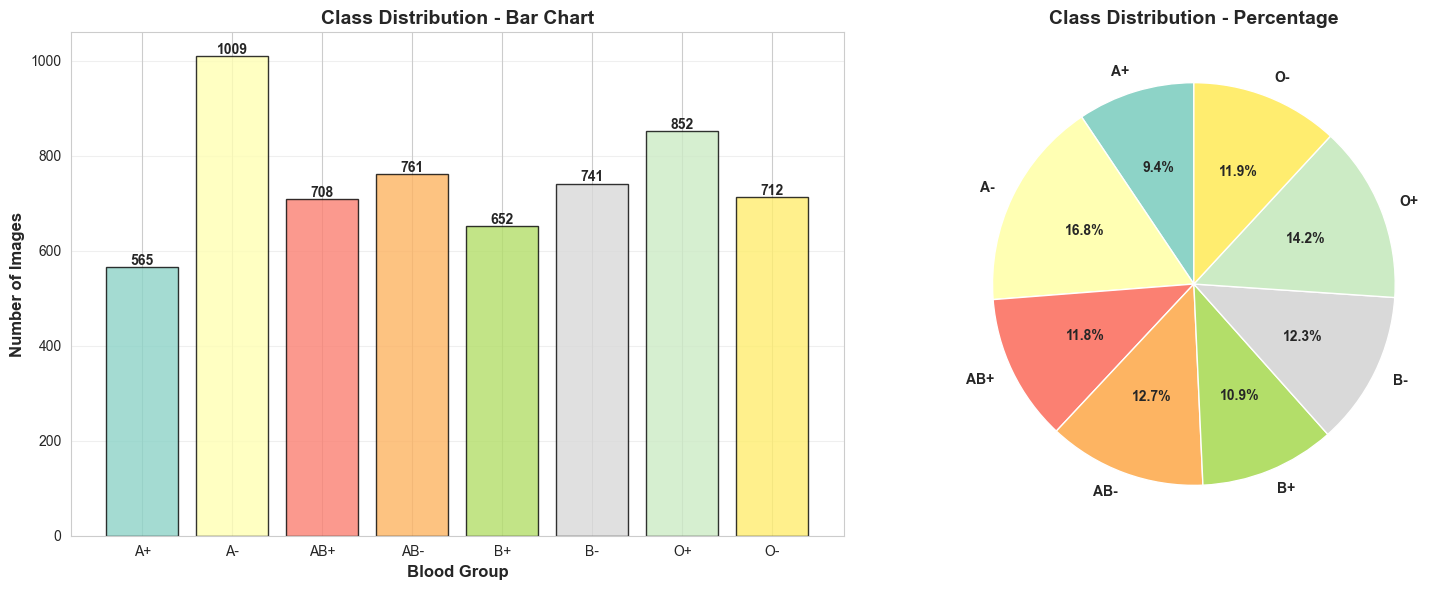


Dataset Balance Analysis:
Total images: 6000
Min class size: 565 (A+)
Max class size: 1009 (A-)
Imbalance ratio: 1.79
Average images per class: 750.0
Std deviation: 133.5


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
colors = plt.cm.Set3(np.linspace(0, 1, len(BLOOD_GROUPS)))
axes[0].bar(df_stats['blood_group'], df_stats['num_images'], color=colors, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Blood Group', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution - Bar Chart', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (group, count) in enumerate(zip(df_stats['blood_group'], df_stats['num_images'])):
    axes[0].text(i, count + 5, str(count), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(df_stats['num_images'], labels=df_stats['blood_group'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution - Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(DATASET_PATH.parent / 'model_results' / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and display balance metrics
total_images = df_stats['num_images'].sum()
min_class = df_stats['num_images'].min()
max_class = df_stats['num_images'].max()
imbalance_ratio = max_class / min_class

print(f"\nDataset Balance Analysis:")
print(f"Total images: {total_images}")
print(f"Min class size: {min_class} ({df_stats.loc[df_stats['num_images'].idxmin(), 'blood_group']})")
print(f"Max class size: {max_class} ({df_stats.loc[df_stats['num_images'].idxmax(), 'blood_group']})")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")
print(f"Average images per class: {df_stats['num_images'].mean():.1f}")
print(f"Std deviation: {df_stats['num_images'].std():.1f}")

## 5. Image Sample Visualization

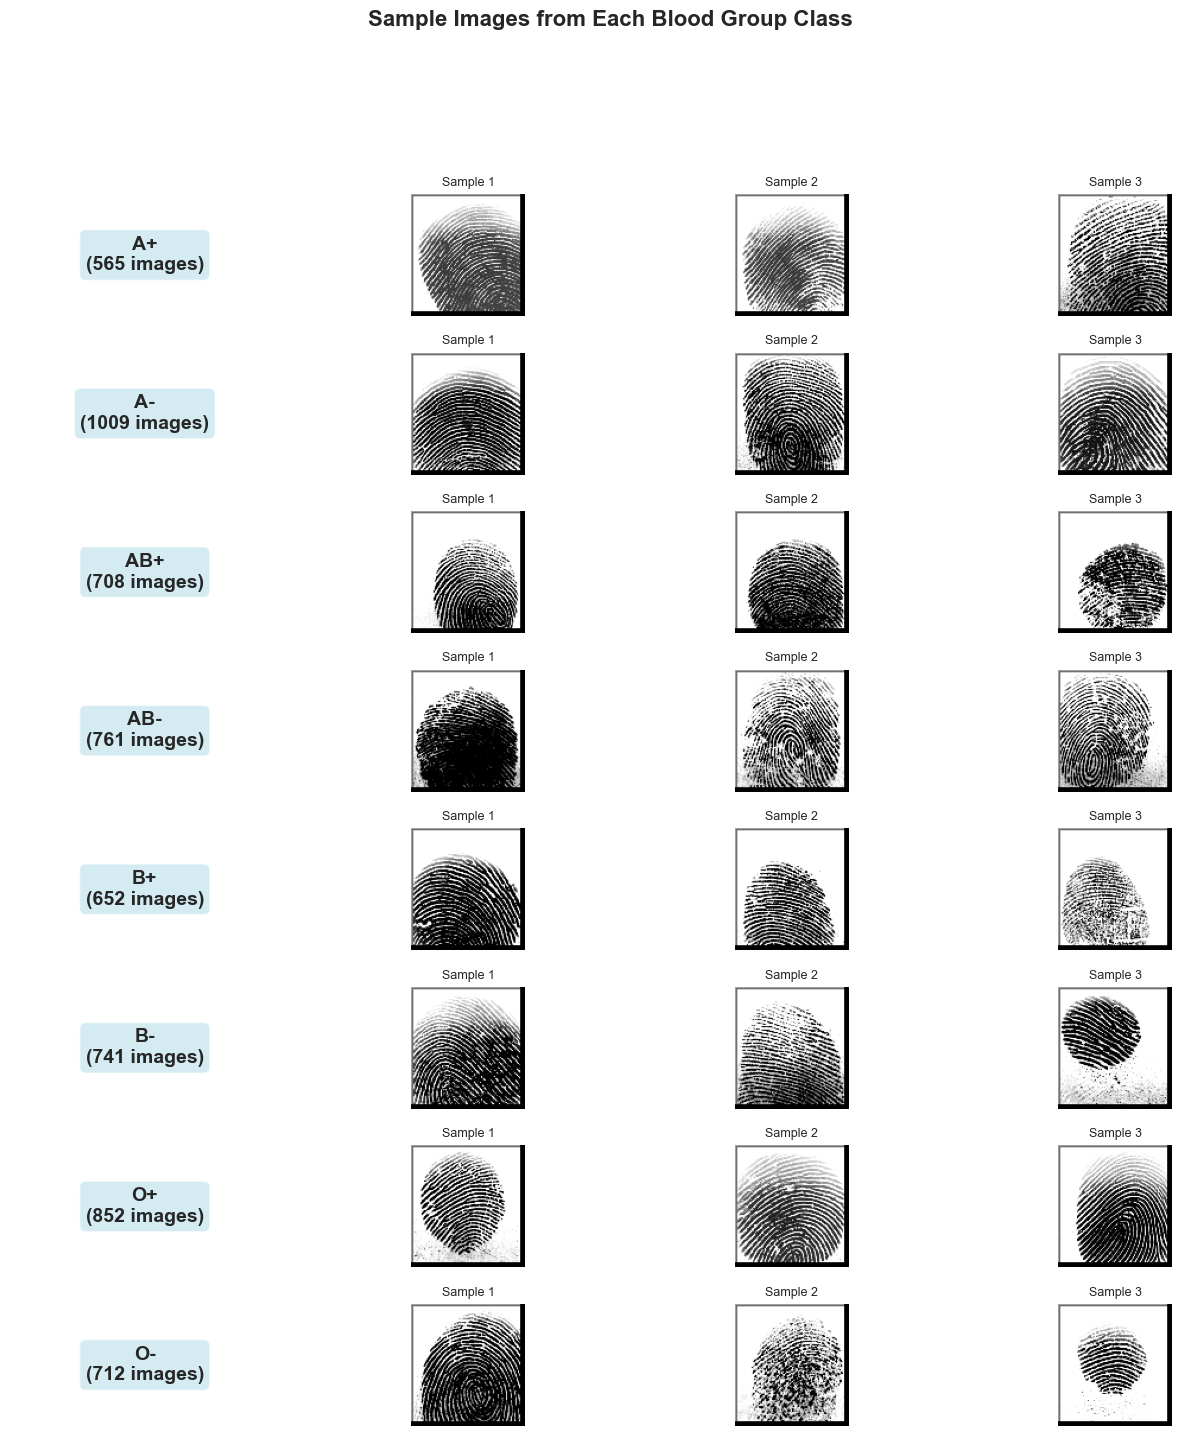

In [5]:
# Display sample images from each class
def display_sample_images(df_stats, num_samples=3):
    """
    Display random sample images from each blood group class
    """
    num_classes = len(df_stats)
    fig = plt.figure(figsize=(16, num_classes * 2))
    gs = GridSpec(num_classes, num_samples + 1, figure=fig, hspace=0.3, wspace=0.2)
    
    for idx, row in df_stats.iterrows():
        blood_group = row['blood_group']
        image_paths = row['image_paths']
        
        # Select random samples
        sample_paths = np.random.choice(image_paths, min(num_samples, len(image_paths)), replace=False)
        
        # Add class label
        ax_label = fig.add_subplot(gs[idx, 0])
        ax_label.text(0.5, 0.5, f"{blood_group}\n({row['num_images']} images)",
                     ha='center', va='center', fontsize=14, fontweight='bold',
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
        ax_label.axis('off')
        
        # Display sample images
        for i, img_path in enumerate(sample_paths):
            ax = fig.add_subplot(gs[idx, i + 1])
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"Sample {i+1}", fontsize=9)
            ax.axis('off')
    
    plt.suptitle('Sample Images from Each Blood Group Class', fontsize=16, fontweight='bold', y=0.995)
    plt.savefig(DATASET_PATH.parent / 'model_results' / 'sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

display_sample_images(df_stats, num_samples=3)

## 6. Image Dimension Analysis

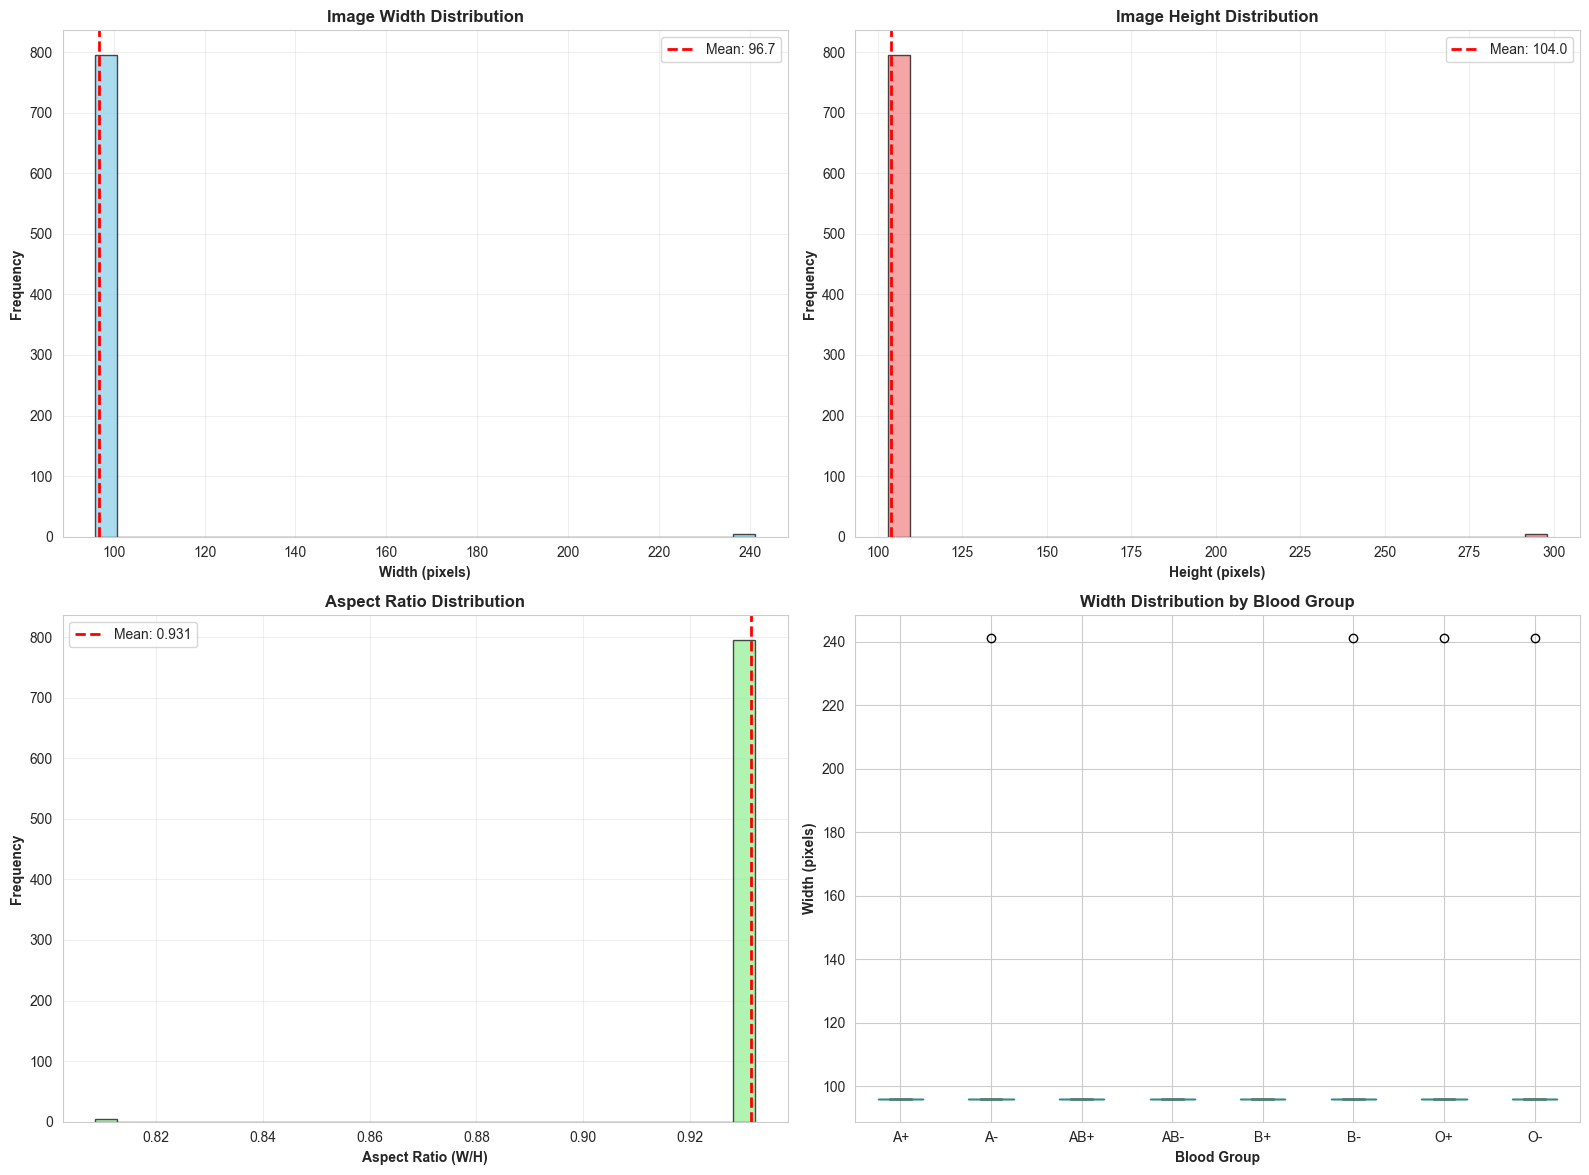


Image Dimension Statistics:
Width - Mean: 96.7, Std: 10.2, Range: [96, 241]
Height - Mean: 104.0, Std: 13.8, Range: [103, 298]
Aspect Ratio - Mean: 0.931, Std: 0.009

Number of unique dimensions: 2
✗ Images have varying dimensions - resizing will be needed


In [6]:
# Analyze image dimensions in detail
def analyze_image_dimensions(df_stats, num_samples=100):
    """
    Analyze dimensions across all images to determine consistency
    """
    all_heights, all_widths, all_aspects = [], [], []
    dimension_data = []
    
    for idx, row in df_stats.iterrows():
        blood_group = row['blood_group']
        image_paths = row['image_paths']
        
        # Sample images for detailed analysis
        sample_paths = np.random.choice(image_paths, min(num_samples, len(image_paths)), replace=False)
        
        for img_path in sample_paths:
            try:
                img = Image.open(img_path)
                w, h = img.size
                aspect = w / h
                
                all_widths.append(w)
                all_heights.append(h)
                all_aspects.append(aspect)
                
                dimension_data.append({
                    'blood_group': blood_group,
                    'width': w,
                    'height': h,
                    'aspect_ratio': aspect
                })
            except Exception as e:
                continue
    
    df_dims = pd.DataFrame(dimension_data)
    
    # Visualize dimension distributions
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Width distribution
    axes[0, 0].hist(all_widths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(np.mean(all_widths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_widths):.1f}')
    axes[0, 0].set_xlabel('Width (pixels)', fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontweight='bold')
    axes[0, 0].set_title('Image Width Distribution', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Height distribution
    axes[0, 1].hist(all_heights, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(np.mean(all_heights), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_heights):.1f}')
    axes[0, 1].set_xlabel('Height (pixels)', fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontweight='bold')
    axes[0, 1].set_title('Image Height Distribution', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Aspect ratio distribution
    axes[1, 0].hist(all_aspects, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(np.mean(all_aspects), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_aspects):.3f}')
    axes[1, 0].set_xlabel('Aspect Ratio (W/H)', fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontweight='bold')
    axes[1, 0].set_title('Aspect Ratio Distribution', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Box plot by class
    df_dims.boxplot(column='width', by='blood_group', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Blood Group', fontweight='bold')
    axes[1, 1].set_ylabel('Width (pixels)', fontweight='bold')
    axes[1, 1].set_title('Width Distribution by Blood Group', fontweight='bold')
    axes[1, 1].get_figure().suptitle('')
    
    plt.tight_layout()
    plt.savefig(DATASET_PATH.parent / 'model_results' / 'dimension_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nImage Dimension Statistics:")
    print(f"Width - Mean: {np.mean(all_widths):.1f}, Std: {np.std(all_widths):.1f}, Range: [{min(all_widths)}, {max(all_widths)}]")
    print(f"Height - Mean: {np.mean(all_heights):.1f}, Std: {np.std(all_heights):.1f}, Range: [{min(all_heights)}, {max(all_heights)}]")
    print(f"Aspect Ratio - Mean: {np.mean(all_aspects):.3f}, Std: {np.std(all_aspects):.3f}")
    
    # Check if dimensions are consistent
    unique_dims = set(zip(all_widths, all_heights))
    print(f"\nNumber of unique dimensions: {len(unique_dims)}")
    if len(unique_dims) == 1:
        print("✓ All images have consistent dimensions")
    else:
        print("✗ Images have varying dimensions - resizing will be needed")
    
    return df_dims

df_dimensions = analyze_image_dimensions(df_stats, num_samples=100)

## 7. Pixel Intensity Analysis

Analyzing pixel intensities...


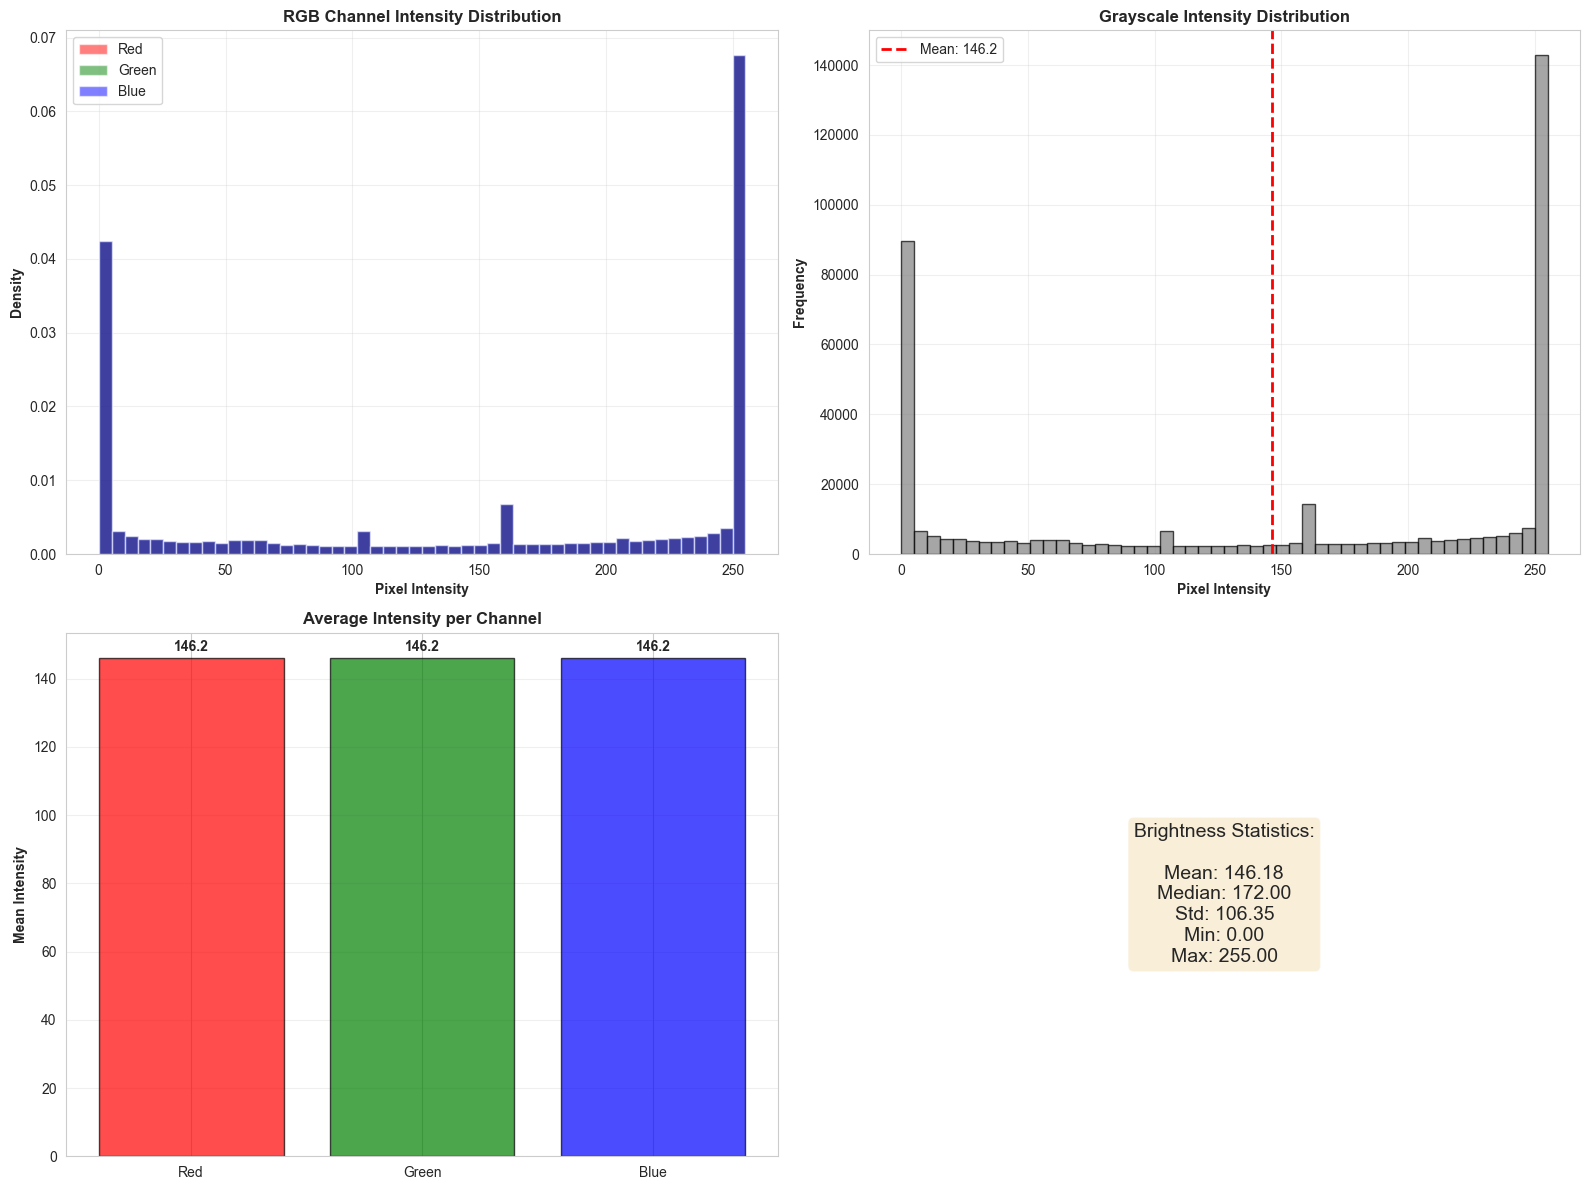


Pixel Intensity Statistics:
Mean: 146.18
Median: 172.00
Std: 106.35
Min: 0.00
Max: 255.00


In [7]:
# Analyze pixel intensity distributions
def analyze_pixel_intensities(df_stats, num_samples=50):
    """
    Analyze pixel intensity distributions across color channels
    """
    r_values, g_values, b_values = [], [], []
    gray_values = []
    
    print("Analyzing pixel intensities...")
    
    for idx, row in df_stats.iterrows():
        image_paths = row['image_paths']
        sample_paths = np.random.choice(image_paths, min(num_samples, len(image_paths)), replace=False)
        
        for img_path in sample_paths:
            try:
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Sample pixels (every 10th pixel to reduce memory)
                r_values.extend(img[:, :, 0].flatten()[::10])
                g_values.extend(img[:, :, 1].flatten()[::10])
                b_values.extend(img[:, :, 2].flatten()[::10])
                
                # Grayscale conversion
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                gray_values.extend(gray.flatten()[::10])
            except Exception as e:
                continue
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # RGB channel histograms
    axes[0, 0].hist(r_values, bins=50, color='red', alpha=0.5, label='Red', density=True)
    axes[0, 0].hist(g_values, bins=50, color='green', alpha=0.5, label='Green', density=True)
    axes[0, 0].hist(b_values, bins=50, color='blue', alpha=0.5, label='Blue', density=True)
    axes[0, 0].set_xlabel('Pixel Intensity', fontweight='bold')
    axes[0, 0].set_ylabel('Density', fontweight='bold')
    axes[0, 0].set_title('RGB Channel Intensity Distribution', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Grayscale histogram
    axes[0, 1].hist(gray_values, bins=50, color='gray', edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(np.mean(gray_values), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(gray_values):.1f}')
    axes[0, 1].set_xlabel('Pixel Intensity', fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontweight='bold')
    axes[0, 1].set_title('Grayscale Intensity Distribution', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Mean intensity per channel
    channel_means = [np.mean(r_values), np.mean(g_values), np.mean(b_values)]
    channel_names = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']
    axes[1, 0].bar(channel_names, channel_means, color=colors, edgecolor='black', alpha=0.7)
    axes[1, 0].set_ylabel('Mean Intensity', fontweight='bold')
    axes[1, 0].set_title('Average Intensity per Channel', fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, val in enumerate(channel_means):
        axes[1, 0].text(i, val + 2, f'{val:.1f}', ha='center', fontweight='bold')
    
    # Brightness statistics
    brightness_stats = {
        'Mean': np.mean(gray_values),
        'Median': np.median(gray_values),
        'Std': np.std(gray_values),
        'Min': np.min(gray_values),
        'Max': np.max(gray_values)
    }
    
    axes[1, 1].axis('off')
    stats_text = "\n".join([f"{k}: {v:.2f}" for k, v in brightness_stats.items()])
    axes[1, 1].text(0.5, 0.5, f"Brightness Statistics:\n\n{stats_text}",
                   ha='center', va='center', fontsize=14,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(DATASET_PATH.parent / 'model_results' / 'pixel_intensity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nPixel Intensity Statistics:")
    for k, v in brightness_stats.items():
        print(f"{k}: {v:.2f}")

analyze_pixel_intensities(df_stats, num_samples=50)

## 8. Color Channel Analysis

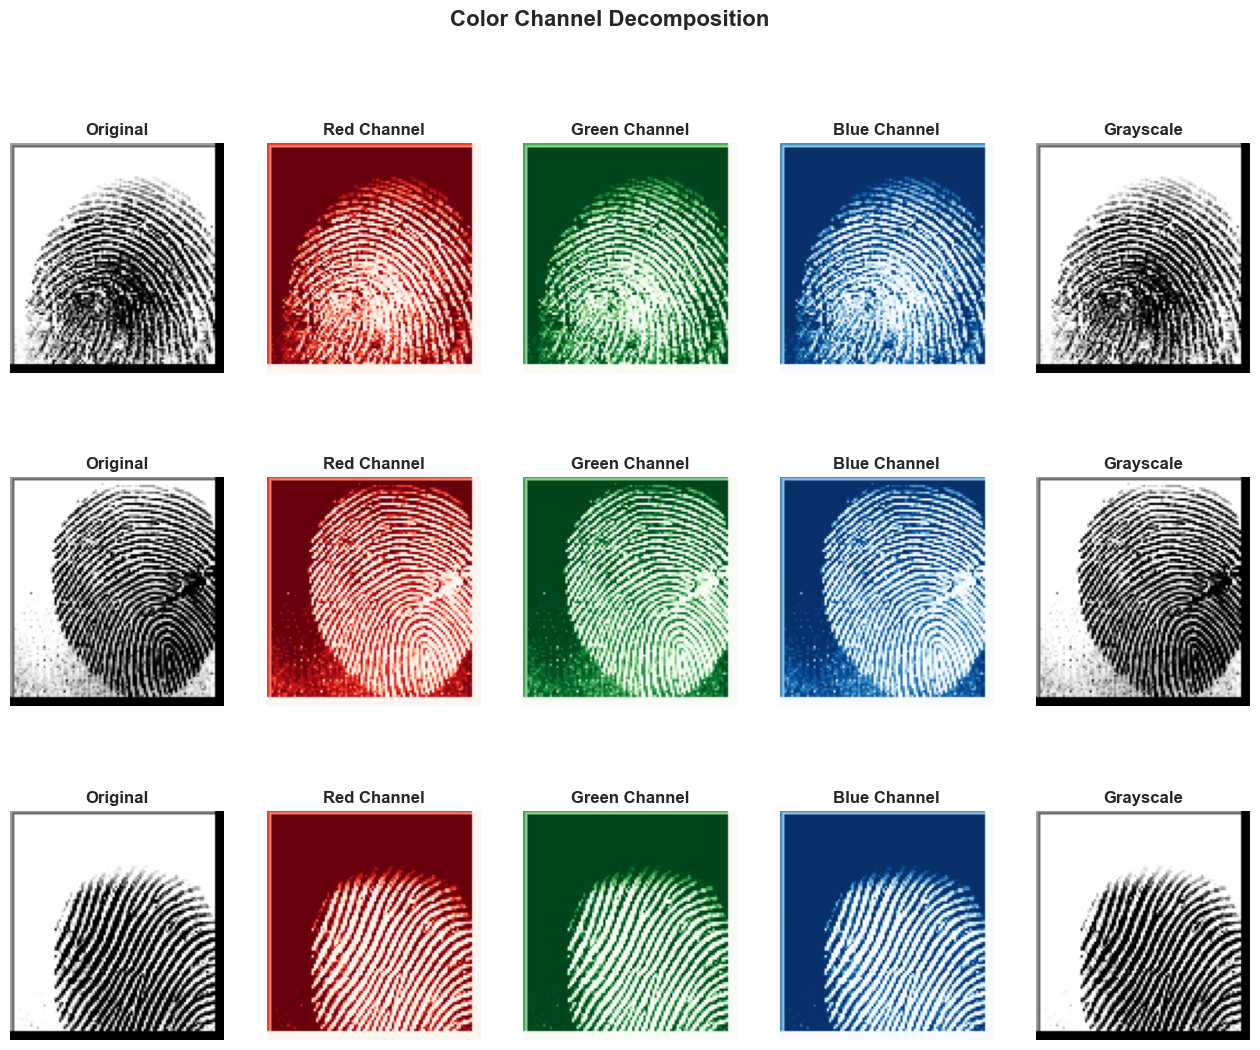

In [8]:
# Visualize color channel separation for sample images
def visualize_color_channels(df_stats, num_samples=2):
    """
    Display RGB channel separation for sample images
    """
    fig = plt.figure(figsize=(16, num_samples * 4))
    gs = GridSpec(num_samples, 5, figure=fig, hspace=0.3, wspace=0.2)
    
    # Select random images from dataset
    all_paths = []
    for idx, row in df_stats.iterrows():
        all_paths.extend(row['image_paths'])
    
    sample_paths = np.random.choice(all_paths, num_samples, replace=False)
    
    for i, img_path in enumerate(sample_paths):
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Original image
        ax = fig.add_subplot(gs[i, 0])
        ax.imshow(img_rgb)
        ax.set_title('Original', fontweight='bold')
        ax.axis('off')
        
        # Red channel
        ax = fig.add_subplot(gs[i, 1])
        ax.imshow(img_rgb[:, :, 0], cmap='Reds')
        ax.set_title('Red Channel', fontweight='bold')
        ax.axis('off')
        
        # Green channel
        ax = fig.add_subplot(gs[i, 2])
        ax.imshow(img_rgb[:, :, 1], cmap='Greens')
        ax.set_title('Green Channel', fontweight='bold')
        ax.axis('off')
        
        # Blue channel
        ax = fig.add_subplot(gs[i, 3])
        ax.imshow(img_rgb[:, :, 2], cmap='Blues')
        ax.set_title('Blue Channel', fontweight='bold')
        ax.axis('off')
        
        # Grayscale
        ax = fig.add_subplot(gs[i, 4])
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        ax.imshow(gray, cmap='gray')
        ax.set_title('Grayscale', fontweight='bold')
        ax.axis('off')
    
    plt.suptitle('Color Channel Decomposition', fontsize=16, fontweight='bold')
    plt.savefig(DATASET_PATH.parent / 'model_results' / 'color_channels.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_color_channels(df_stats, num_samples=3)

## 9. Data Augmentation Preview

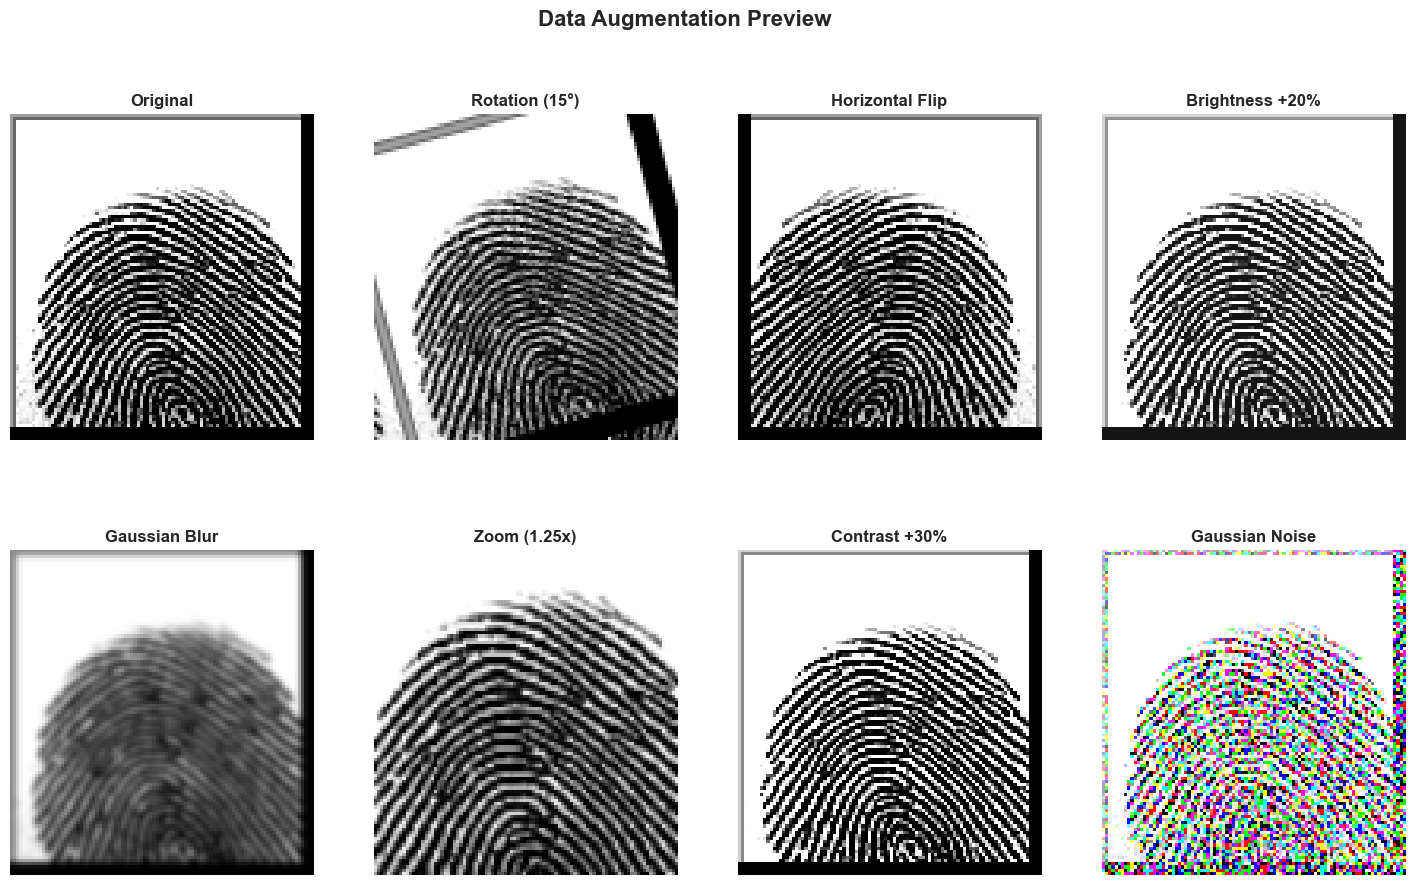

In [9]:
# Preview common augmentation techniques
def preview_augmentations(df_stats):
    """
    Show effects of common augmentation techniques
    """
    # Select a random image
    all_paths = []
    for idx, row in df_stats.iterrows():
        all_paths.extend(row['image_paths'])
    
    img_path = np.random.choice(all_paths)
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(18, 10))
    gs = GridSpec(2, 4, figure=fig, hspace=0.3, wspace=0.2)
    
    # Original
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(img)
    ax.set_title('Original', fontweight='bold', fontsize=12)
    ax.axis('off')
    
    # Rotation
    ax = fig.add_subplot(gs[0, 1])
    height, width = img.shape[:2]
    center = (width // 2, height // 2)
    matrix = cv2.getRotationMatrix2D(center, 15, 1.0)
    rotated = cv2.warpAffine(img, matrix, (width, height), borderMode=cv2.BORDER_REFLECT)
    ax.imshow(rotated)
    ax.set_title('Rotation (15°)', fontweight='bold', fontsize=12)
    ax.axis('off')
    
    # Horizontal flip
    ax = fig.add_subplot(gs[0, 2])
    flipped = cv2.flip(img, 1)
    ax.imshow(flipped)
    ax.set_title('Horizontal Flip', fontweight='bold', fontsize=12)
    ax.axis('off')
    
    # Brightness adjustment
    ax = fig.add_subplot(gs[0, 3])
    bright = cv2.convertScaleAbs(img, alpha=1.2, beta=20)
    ax.imshow(bright)
    ax.set_title('Brightness +20%', fontweight='bold', fontsize=12)
    ax.axis('off')
    
    # Gaussian blur
    ax = fig.add_subplot(gs[1, 0])
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    ax.imshow(blurred)
    ax.set_title('Gaussian Blur', fontweight='bold', fontsize=12)
    ax.axis('off')
    
    # Zoom (crop and resize)
    ax = fig.add_subplot(gs[1, 1])
    h, w = img.shape[:2]
    crop_size = int(0.8 * min(h, w))
    start_h, start_w = (h - crop_size) // 2, (w - crop_size) // 2
    cropped = img[start_h:start_h+crop_size, start_w:start_w+crop_size]
    zoomed = cv2.resize(cropped, (w, h))
    ax.imshow(zoomed)
    ax.set_title('Zoom (1.25x)', fontweight='bold', fontsize=12)
    ax.axis('off')
    
    # Contrast adjustment
    ax = fig.add_subplot(gs[1, 2])
    contrast = cv2.convertScaleAbs(img, alpha=1.3, beta=0)
    ax.imshow(contrast)
    ax.set_title('Contrast +30%', fontweight='bold', fontsize=12)
    ax.axis('off')
    
    # Noise addition
    ax = fig.add_subplot(gs[1, 3])
    noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
    noisy = cv2.add(img, noise)
    ax.imshow(noisy)
    ax.set_title('Gaussian Noise', fontweight='bold', fontsize=12)
    ax.axis('off')
    
    plt.suptitle('Data Augmentation Preview', fontsize=16, fontweight='bold')
    plt.savefig(DATASET_PATH.parent / 'model_results' / 'augmentation_preview.png', dpi=300, bbox_inches='tight')
    plt.show()

preview_augmentations(df_stats)

## 10. Dataset Summary Report

In [10]:
# Generate comprehensive summary report
print("="*80)
print("DATASET SUMMARY REPORT")
print("="*80)

print("\n1. DATASET OVERVIEW:")
print(f"   - Total classes: {len(BLOOD_GROUPS)}")
print(f"   - Total images: {df_stats['num_images'].sum()}")
print(f"   - Image format: BMP")
print(f"   - Task: Multi-class image classification")

print("\n2. CLASS DISTRIBUTION:")
for idx, row in df_stats.iterrows():
    percentage = (row['num_images'] / df_stats['num_images'].sum()) * 100
    print(f"   - {row['blood_group']:4s}: {row['num_images']:4d} images ({percentage:5.2f}%)")

print("\n3. IMAGE PROPERTIES:")
print(f"   - Average width: {df_stats['avg_width'].mean():.1f} px")
print(f"   - Average height: {df_stats['avg_height'].mean():.1f} px")
print(f"   - Average file size: {df_stats['avg_file_size_kb'].mean():.1f} KB")

print("\n4. KEY INSIGHTS:")
imbalance = df_stats['num_images'].max() / df_stats['num_images'].min()
if imbalance > 1.5:
    print(f"   ⚠ Class imbalance detected (ratio: {imbalance:.2f})")
    print("   → Consider: weighted loss, oversampling, or augmentation")
else:
    print("   ✓ Classes are relatively balanced")

print("\n5. RECOMMENDATIONS FOR PREPROCESSING:")
print("   - Resize images to consistent dimensions (e.g., 224×224 or 256×256)")
print("   - Apply normalization (ImageNet stats or dataset-specific)")
print("   - Use data augmentation to increase diversity")
print("   - Consider grayscale conversion if color is not critical")
print("   - Split: 70% train, 15% validation, 15% test (stratified)")

print("\n6. SUGGESTED AUGMENTATIONS:")
print("   - Rotation: ±15-20 degrees")
print("   - Horizontal/vertical flips")
print("   - Brightness/contrast adjustments: ±20%")
print("   - Zoom: 0.8-1.2x")
print("   - Gaussian noise/blur")
print("   - Random crops and shifts")

print("\n" + "="*80)
print("Visualization complete! All plots saved to model_results folder.")
print("="*80)

DATASET SUMMARY REPORT

1. DATASET OVERVIEW:
   - Total classes: 8
   - Total images: 6000
   - Image format: BMP
   - Task: Multi-class image classification

2. CLASS DISTRIBUTION:
   - A+  :  565 images ( 9.42%)
   - A-  : 1009 images (16.82%)
   - AB+ :  708 images (11.80%)
   - AB- :  761 images (12.68%)
   - B+  :  652 images (10.87%)
   - B-  :  741 images (12.35%)
   - O+  :  852 images (14.20%)
   - O-  :  712 images (11.87%)

3. IMAGE PROPERTIES:
   - Average width: 96.7 px
   - Average height: 104.0 px
   - Average file size: 39.6 KB

4. KEY INSIGHTS:
   ⚠ Class imbalance detected (ratio: 1.79)
   → Consider: weighted loss, oversampling, or augmentation

5. RECOMMENDATIONS FOR PREPROCESSING:
   - Resize images to consistent dimensions (e.g., 224×224 or 256×256)
   - Apply normalization (ImageNet stats or dataset-specific)
   - Use data augmentation to increase diversity
   - Consider grayscale conversion if color is not critical
   - Split: 70% train, 15% validation, 15% test

## 11. Save Analysis Results

In [11]:
# Save statistics to CSV
output_path = DATASET_PATH.parent / 'model_results' / 'dataset_statistics.csv'
df_stats[['blood_group', 'num_images', 'avg_height', 'avg_width', 'avg_file_size_kb']].to_csv(output_path, index=False)
print(f"\nStatistics saved to: {output_path}")

# Save dimension analysis
if 'df_dimensions' in locals():
    dim_output = DATASET_PATH.parent / 'model_results' / 'dimension_analysis.csv'
    df_dimensions.to_csv(dim_output, index=False)
    print(f"Dimension analysis saved to: {dim_output}")

print("\n✓ Data visualization complete!")
print("\nNext step: Run the data preprocessing notebook.")


Statistics saved to: C:\Users\phoga\Desktop\HemoPrint\model_results\dataset_statistics.csv
Dimension analysis saved to: C:\Users\phoga\Desktop\HemoPrint\model_results\dimension_analysis.csv

✓ Data visualization complete!

Next step: Run the data preprocessing notebook.
